In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import io
import pickle
import torch
import numpy as np
from scipy.stats import wilcoxon
from matplotlib.gridspec import GridSpec
import timm

# Introduction

## All

In [256]:
df = pd.read_csv('../experiments/2025-W12-03-20/tables/pytorch_models__all.csv')

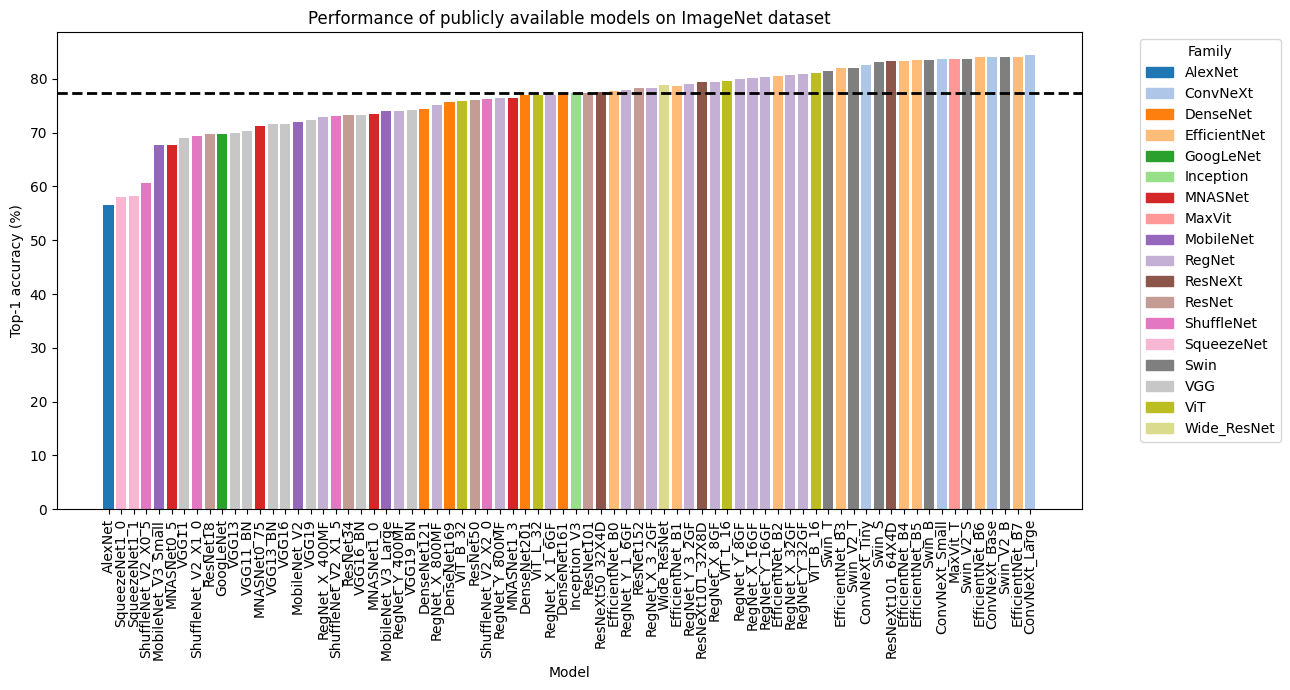

In [257]:
unique_families = df['Family'].unique()
color_palette = plt.cm.tab20.colors

family_colors = {fam: color_palette[i % len(color_palette)] for i, fam in enumerate(unique_families)}
df['Color'] = df['Family'].map(family_colors)

sorted_df = df.sort_values('Acc@1', ascending=True)

plt.figure(figsize=(13, 7))
bars = plt.bar(
    x=sorted_df['Model'],
    height=sorted_df['Acc@1'],
    color=sorted_df['Color']
)

inception_acc = sorted_df.loc[sorted_df['Model'] == 'Inception_V3', 'Acc@1'].values
plt.axhline(y=inception_acc, color='black', linestyle='--', linewidth=2, label='Inception_V3')

plt.xticks(rotation=90)
plt.xlabel("Model")
plt.ylabel("Top-1 accuracy (%)")
plt.title("Performance of publicly available models on ImageNet dataset")

legend_patches = [mpatches.Patch(color=color, label=label) for label, color in family_colors.items()]
plt.legend(handles=legend_patches, title="Family", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Comparable

In [258]:
filtered_df = pd.read_csv('../experiments/2025-W12-03-20/tables/pytorch_models__comparable.csv')

filtered_df['Color'] = filtered_df['Family'].map(family_colors)

family_order = (
    filtered_df.groupby('Family')['Acc@1']
    .max()
    .sort_values(ascending=True)
    .index
)

filtered_df['Family'] = pd.Categorical(
    filtered_df['Family'],
    categories=family_order,
    ordered=True
)

sorted_df = filtered_df.sort_values(by=['Family', 'Acc@1'], ascending=[True, True]).reset_index(drop=True)

def parse_params(value):
    if isinstance(value, str):
        multipliers = {
            'K': 1_000,
            'M': 1_000_000,
            'B': 1_000_000_000
        }
        try:
            if value[-1] in multipliers:
                return float(value[:-1]) * multipliers[value[-1]]
            else:
                return float(value)
        except ValueError:
            return None
    return value 
sorted_df['ParamCount'] = sorted_df['Params'].apply(parse_params)

gap_size = 1
x_positions = []
current_x = 0
family_indices = []

for family, group in sorted_df.groupby('Family'):
    indices = list(range(current_x, current_x + len(group)))
    x_positions.extend(indices)
    family_indices.append((family, indices))
    current_x += len(group) + gap_size

sorted_df['x'] = x_positions

/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/1712695705.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for family, group in sorted_df.groupby('Family'):


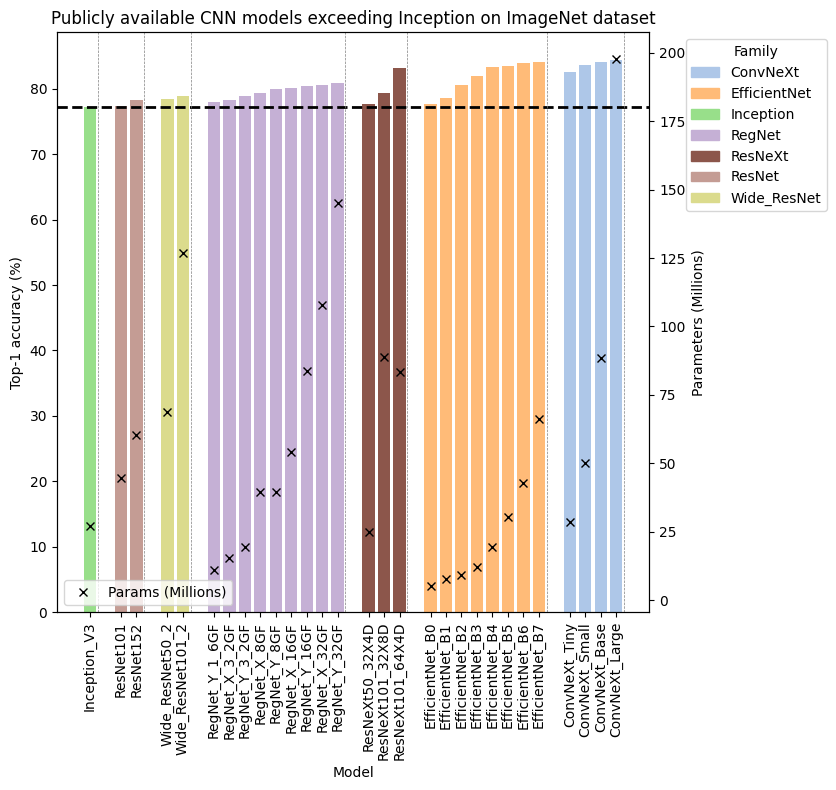

In [259]:
fig, ax1 = plt.subplots(figsize=(8.5, 8))

bars = ax1.bar(
    x=sorted_df['x'],
    height=sorted_df['Acc@1'],
    color=sorted_df['Color'],
    label="Top-1 accuracy"
)
ax1.set_xlabel("Model")
ax1.set_ylabel("Top-1 accuracy (%)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(sorted_df['x'])
ax1.set_xticklabels(sorted_df['Model'], rotation=90)

inception_acc = sorted_df.loc[sorted_df['Model'] == 'Inception_V3', 'Acc@1'].values
ax1.axhline(y=inception_acc, color='black', linestyle='--', linewidth=2, label='Inception_V3')

ax2 = ax1.twinx()
ax2.plot(
    sorted_df['x'],
    sorted_df['ParamCount'] / 1e6,
    color='black',
    marker='x',
    linestyle='',
    linewidth=2,
    label="Params (Millions)"
)
ax2.set_ylabel("Parameters (Millions)", color='black')
ax2.tick_params(axis='y', labelcolor='black')

for family, indices in family_indices:
    last_index = indices[-1]
    ax1.axvline(x=last_index + 0.5, color='gray', linestyle='--', linewidth=0.5)

legend_patches = [mpatches.Patch(color=color, label=label) for label, color in family_colors.items() if label in sorted_df['Family'].unique()]
ax1.legend(handles=legend_patches, title="Family", bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(loc='lower left')

plt.title("Publicly available CNN models exceeding Inception on ImageNet dataset")
fig.tight_layout()
plt.show()

## Comparable (mini)

In [260]:
def plot_accuracy_comparison(file_path, family_colors, alpha_families=None, gap_size=1):

    filtered_df = pd.read_csv(file_path)
    filtered_df['Color'] = filtered_df['Family'].map(family_colors)

    family_order = (
        filtered_df.groupby('Family')['Acc@1']
        .max()
        .sort_values(ascending=True)
        .index
    )

    filtered_df['Family'] = pd.Categorical(
        filtered_df['Family'],
        categories=family_order,
        ordered=True
    )

    sorted_df = filtered_df.sort_values(by=['Family', 'Acc@1'], ascending=[True, True]).reset_index(drop=True)

    sorted_df['ParamCount'] = sorted_df['Params'].apply(parse_params)

    x_positions = []
    current_x = 0
    family_indices = []

    for family, group in sorted_df.groupby('Family'):
        indices = list(range(current_x, current_x + len(group)))
        x_positions.extend(indices)
        family_indices.append((family, indices))
        current_x += len(group) + gap_size 
    sorted_df['x'] = x_positions

    fig, ax1 = plt.subplots(figsize=(4, 2.3))

    bars = ax1.bar(
        x=sorted_df['x'],
        height=sorted_df['Acc@1'],
        color=sorted_df['Color'],
        label="Top-1 accuracy"
    )

    if alpha_families:
        for i, family in enumerate(sorted_df['Family']):
            if family in alpha_families:
                bars[i].set_alpha(0.2)

    ax1.set_xlabel("Model")
    ax1.set_ylabel("Top-1 accuracy (%)", color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_xticks([])

    inception_acc = sorted_df.loc[sorted_df['Model'] == 'Inception_V3', 'Acc@1'].values
    ax1.axhline(y=inception_acc, color='black', linestyle='--', linewidth=2, label='Inception_V3')

    for family, indices in family_indices:
        last_index = indices[-1]
        ax1.axvline(x=last_index + 0.5, color='gray', linestyle='--', linewidth=0.5)

    legend_patches = [mpatches.Patch(color=color, label=label) for label, color in family_colors.items() if label in sorted_df['Family'].unique() and label not in alpha_families]
    ax1.legend(handles=legend_patches, title="Family", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title("")
    fig.tight_layout()
    plt.show()

/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/3572797131.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for family, group in sorted_df.groupby('Family'):


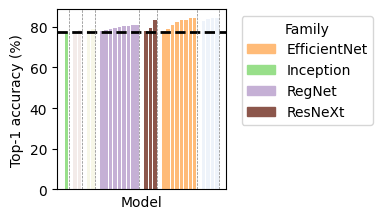

In [261]:
alpha_families = ['ResNet', 'Wide_ResNet', 'ConvNeXt']
plot_accuracy_comparison('/Users/lune/Downloads/pytorch_models__comparable_with_baseline2.csv', family_colors, alpha_families)

# Check models

In [ ]:
all_models = timm.list_models()

resnet_models = [m for m in all_models if 'resnet' in m.lower()]
for model in resnet_models:
    print(model)

# Results

In [262]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)


def load_pickle_data(file_path):
    with open(file_path, 'rb') as df:
        data = CPU_Unpickler(df).load() # data = pickle.load(file) for CPU
    return data


def plot_epoch_progression(datasets, model_names, colors, n_bootstrap=1000, confidence_level=0.95, metric_key='f1', ax=None):

    for model_idx, data in enumerate(datasets):
        metrics_to_save = []

        for fold in data['folds']:
            metrics = [epoch['validation'][metric_key] for epoch in fold['epochs']]
            metrics_to_save.append(metrics)

        metrics_to_save = np.array(metrics_to_save)
        mean_metric = np.mean(metrics_to_save, axis=0)

        bootstrap_means = np.zeros((n_bootstrap, metrics_to_save.shape[1]))
        for i in range(n_bootstrap):
            sample_indices = np.random.choice(metrics_to_save.shape[0], metrics_to_save.shape[0], replace=True)
            bootstrap_means[i, :] = np.mean(metrics_to_save[sample_indices, :], axis=0)

        lower_bound = np.percentile(bootstrap_means, (1 - confidence_level) / 2 * 100, axis=0)
        upper_bound = np.percentile(bootstrap_means, (1 + confidence_level) / 2 * 100, axis=0)

        epochs = np.arange(1, metrics_to_save.shape[1] + 1)
        ax.plot(epochs, mean_metric, color=colors[model_idx], label=f'{model_names[model_idx]} Mean', linewidth=2)
        ax.fill_between(epochs, lower_bound, upper_bound, color=colors[model_idx], alpha=0.2,
                        label=f'{model_names[model_idx]} {int(confidence_level*100)}% CI')

    ax.set_title(f"{metric_key.upper()} epoch progression", fontsize=13)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel(metric_key.upper(), fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(title="Models", fontsize=10, loc='lower right')
    ax.set_ylim(0, 1)


def plot_final_epoch(datasets, model_names, colors, blank_space, metric_key='f1', ax=None):

    final_metrics = [
        [fold['epochs'][-1]['validation'][metric_key] for fold in data['folds']]
        for data in datasets
    ]

    stat, p = wilcoxon(final_metrics[0], final_metrics[1])
    print(f"{model_names[0]} vs {model_names[1]}: p-value = {p:.5f}")

    box = ax.boxplot(final_metrics, labels=model_names, patch_artist=True,
                     medianprops=dict(color='black'),
                     flierprops=dict(marker='o', markerfacecolor='black', markersize=3, linestyle='none', markeredgecolor='gray'))

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    positions = [1, 2]

    for pos, group, color in zip(positions, final_metrics, colors):
        jitter = np.random.normal(0, 0.00, size=len(group))
        ax.scatter([pos + j for j in jitter], group, alpha=0.9, color=color,
                   edgecolor='black', linewidth=1, zorder=3)

    for i in range(len(final_metrics[0])):
        ax.plot([1 + np.random.normal(0, 0.00), 2 + np.random.normal(0, 0.00)], 
                [final_metrics[0][i], final_metrics[1][i]], color='black', alpha=0.2, zorder=2, linestyle='--')

    means = [np.median(m) for m in final_metrics]
    ax.scatter(positions, means, color='black', marker='_', s=1000, zorder=10, edgecolor='black', linewidth=3, alpha=1)

    y_max = max([max(m) for m in final_metrics]) + blank_space
    ax.text(1.5, y_max, f'p = {p:.3g}', ha='center', va='bottom', fontsize=10)

    ax.set_xticklabels(model_names, rotation=90)
    ax.set_ylabel(metric_key.upper())
    ax.set_title(f"{metric_key.upper()} final epoch comparison", fontsize=13)
    ax.grid(True, linestyle='--', alpha=0.7)

    ax.legend_.remove() if ax.get_legend() else None


def kfold_CV_table(
    datasets,
    model_names,
    list_metrics,
    use_last_epoch=True
):

    foldwise_results = {name: {metric: [] for metric in list_metrics} for name in model_names}

    for model_idx, data in enumerate(datasets):
        model_name = model_names[model_idx]
        
        for metric in list_metrics:
            metric_per_fold = []
            for fold in data['folds']:
                values = [epoch['validation'][metric] for epoch in fold['epochs']]
                metric_value = values[-1] if use_last_epoch else max(values)
                metric_per_fold.append(metric_value)
            foldwise_results[model_name][metric] = metric_per_fold

    rows = []
    model1, model2 = model_names

    for metric in list_metrics:
        scores1 = foldwise_results[model1][metric]
        scores2 = foldwise_results[model2][metric]

        mean1 = np.mean(scores1)
        std1 = np.std(scores1)
        mean2 = np.mean(scores2)
        std2 = np.std(scores2)

        if mean1 > mean2:
            value1 = f"{mean1:.4f} ± {std1:.4f} ↑"
            value2 = f"{mean2:.4f} ± {std2:.4f}"
        elif mean2 > mean1:
            value1 = f"{mean1:.4f} ± {std1:.4f}"
            value2 = f"{mean2:.4f} ± {std2:.4f} ↑"
        else:
            value1 = f"{mean1:.4f} ± {std1:.4f}"
            value2 = f"{mean2:.4f} ± {std2:.4f}"


        p = wilcoxon(scores1, scores2).pvalue
        if p < 0.01:
            signif = "**"
        elif p < 0.05:
            signif = "*"
        elif p < 0.1:
            signif = "†"
        else:
            signif = " "


        rows.append({
            "Metric": metric,
            f"{model1}": value1,
            f"{model2}": value2,
            "p-value": f"{p:.4f}{signif}"
        })

    df_comparison = pd.DataFrame(rows)
    return df_comparison.set_index("Metric")


model_params = {'Inception_V3': "27.2M",
              'EfficientNet_b7': "66.3M",
              'RegNet_Y_32': "145.0M",
              'ConxNext_large':"197.8M",
              'RegNext101_64X4D':"83.5M"}

def tensor_to_value(obj):
    if isinstance(obj, torch.Tensor):
        return obj.item()
    elif isinstance(obj, dict):
        return {k: tensor_to_value(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [tensor_to_value(v) for v in obj]
    else:
        return obj

In [263]:
results_inception = tensor_to_value(load_pickle_data('../experiments/2025-W18-04-29/results/inception_v3_500000.pkl'))
results_efficientnet = tensor_to_value(load_pickle_data('../experiments/2025-W18-04-29/results/efficientnet_b7_500000.pkl'))
results_regnet = tensor_to_value(load_pickle_data('../experiments/2025-W18-04-29/results/regnety_032_500000.pkl'))
results_resnext = tensor_to_value(load_pickle_data('../experiments/2025-W18-04-29/results/resnext101_64x4d_500000.pkl'))

/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/3457609974.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), ma

## RegNet

In [266]:
results = [results_inception, results_regnet]
model_names = ['Inception_V3', 'RegNet_Y_32']
colors = [family_colors['Inception'], family_colors['RegNet']]

Inception_V3 vs RegNet_Y_32: p-value = 0.04883


/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/3457609974.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(positions, means, color='black', marker='_', s=1000, zorder=10, edgecolor='black', linewidth=3, alpha=1)


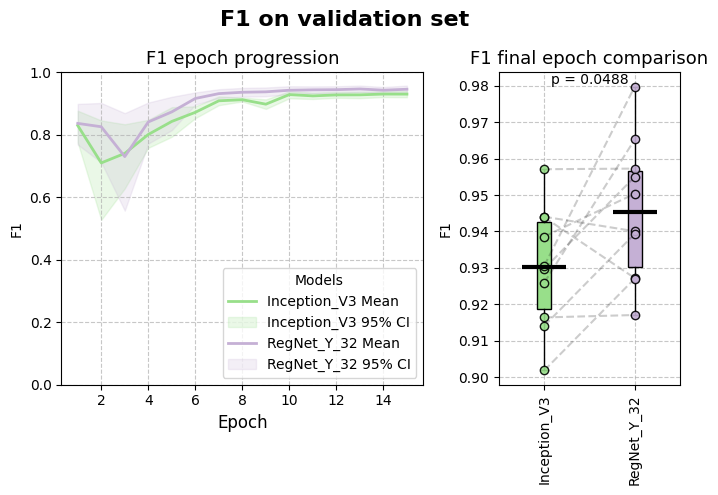

In [267]:
metric = 'f1'
fig = plt.figure(figsize=(7, 5))
gs = GridSpec(1, 2, width_ratios=[2, 1], figure=fig)
fig.suptitle(f"{metric.upper()} on validation set", fontsize=16, fontweight='bold')

# epoch progression
ax1 = fig.add_subplot(gs[0])
plot_epoch_progression(
    datasets=results,
    model_names=model_names,
    colors=colors,
    metric_key=metric,
    ax=ax1
)

# final epoch comparison
ax2 = fig.add_subplot(gs[1])
plot_final_epoch(
    datasets=results,
    model_names=model_names,
    colors=colors,
    blank_space=0.00,
    metric_key=metric,
    ax=ax2 
)

plt.tight_layout()
plt.show()

Inception_V3 vs RegNet_Y_32: p-value = 0.04883
Inception_V3 vs RegNet_Y_32: p-value = 0.04883


/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/3457609974.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(positions, means, color='black', marker='_', s=1000, zorder=10, edgecolor='black', linewidth=3, alpha=1)
/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/3457609974.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(positions, means, color='black', marker='_', s=1000, zorder=10, edgecolor='black', linewidth=3, alpha=1)


Inception_V3 vs RegNet_Y_32: p-value = 0.04883


/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/3457609974.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(positions, means, color='black', marker='_', s=1000, zorder=10, edgecolor='black', linewidth=3, alpha=1)


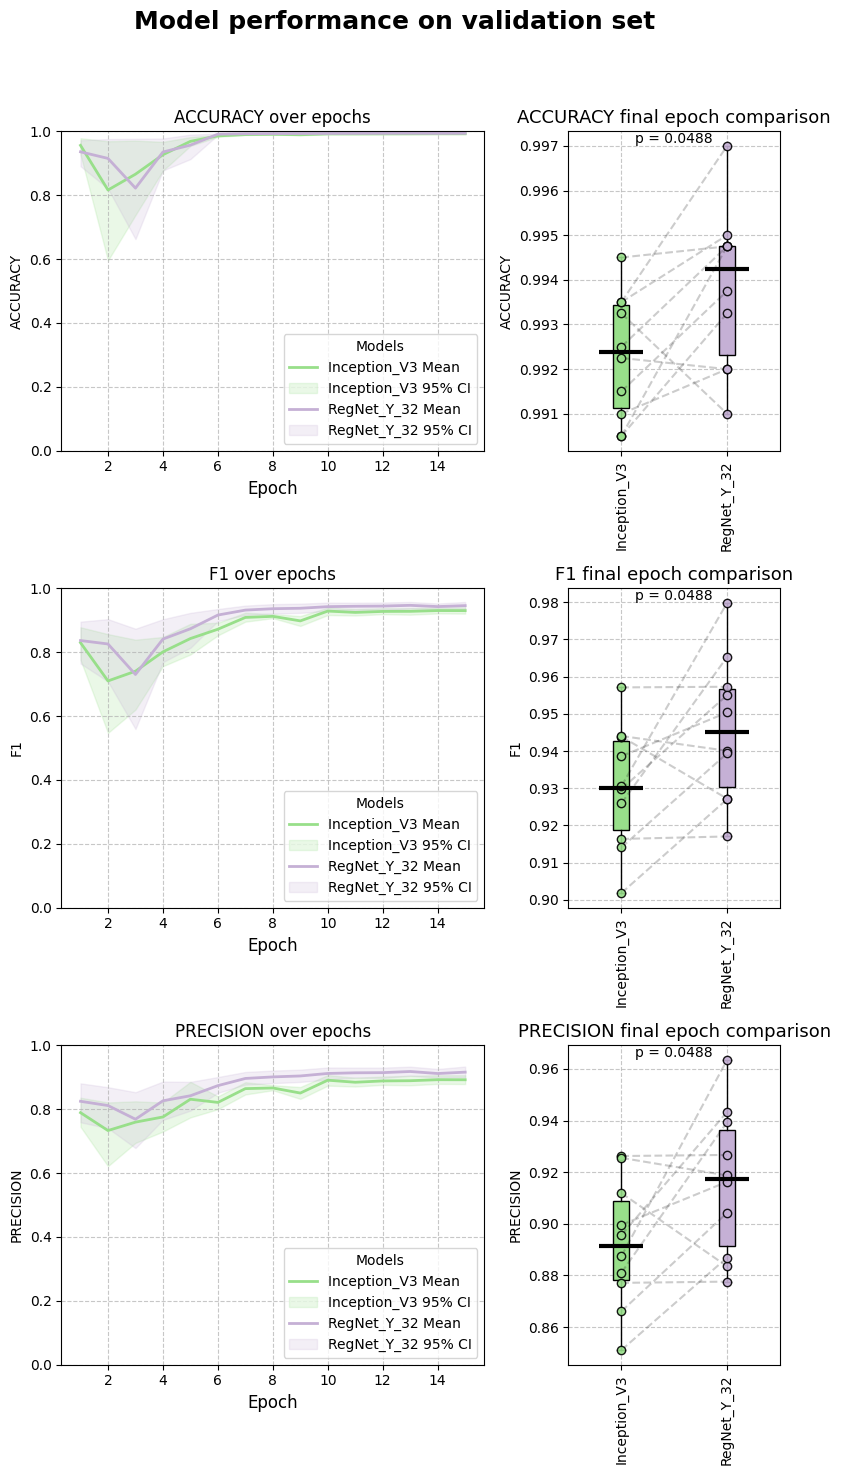

In [268]:
metrics = ['accuracy', 'f1', 'precision']

num_metrics = len(metrics)

fig = plt.figure(figsize=(8, 5 * num_metrics))
gs = GridSpec(num_metrics, 2, width_ratios=[2, 1], figure=fig)

for i, metric in enumerate(metrics):
    fig.suptitle("Model performance on validation set", fontsize=18, fontweight='bold')

    # Epoch progression plot
    ax1 = fig.add_subplot(gs[i, 0])
    plot_epoch_progression(
        datasets=results,
        model_names=model_names,
        colors=colors,
        metric_key=metric,
        ax=ax1
    )
    ax1.set_title(f'{metric.upper()} over epochs')

    # Final epoch boxplot with stats
    ax2 = fig.add_subplot(gs[i, 1])
    plot_final_epoch(
        datasets=results,
        model_names=model_names,
        colors=colors,
        blank_space=0.0000001,
        metric_key=metric,
        ax=ax2
    )

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# 10-fold CV, specifications 
df = kfold_CV_table(results, model_names, list_metrics=['inference_time', 'accuracy','f1', 'precision','recall'])
# specifications
params = {col: model_params.get(col, None) for col in df.columns}
df.loc[len(df)] = params
df.to_csv(f'../experiments/2025-W18-04-29/tables/{model_names[1]}.csv')

In [170]:
pd.read_csv(f'../experiments/2025-W18-04-29/tables/{model_names[1]}__10fold_CV_results.csv')

,Metric,Inception V3,RegNetY 32,p-value
0,Accuracy,0.9923 ± 0.0013,0.9938 ± 0.0017 ↑,0.0488*
1,F1,0.9302 ± 0.0156,0.9458 ± 0.0184 ↑,0.0488*
2,Precision,0.8922 ± 0.0234,0.9160 ± 0.0268 ↑,0.0488*
3,Recall,0.9873 ± 0.0107 ↑,0.9863 ± 0.0118,1.0000


## ResNeXt

In [269]:
metric = 'f1'
results = [results_inception, results_resnext]
model_names = ['Inception_V3', 'ResNeXt101_64X4D']
colors = [family_colors['Inception'], family_colors['ResNeXt']]

Inception_V3 vs ResNeXt101_64X4D: p-value = 0.08398


/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/3457609974.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(positions, means, color='black', marker='_', s=1000, zorder=10, edgecolor='black', linewidth=3, alpha=1)


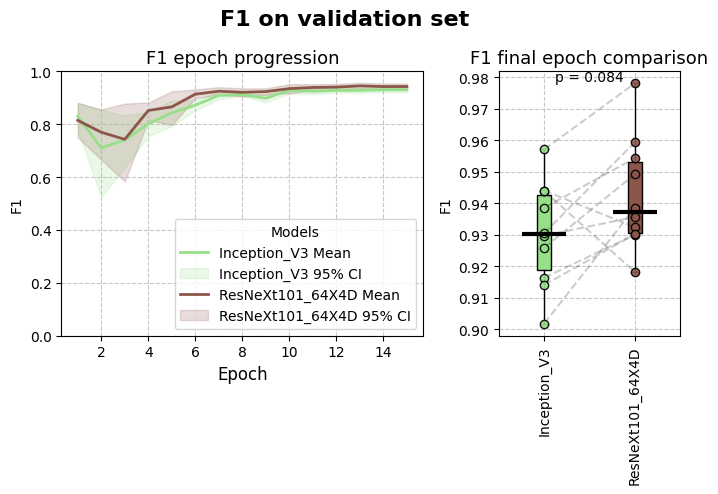

In [270]:
fig = plt.figure(figsize=(7, 5))
gs = GridSpec(1, 2, width_ratios=[2, 1], figure=fig)
fig.suptitle(f"{metric.upper()} on validation set", fontsize=16, fontweight='bold')

# epoch progression
ax1 = fig.add_subplot(gs[0])
plot_epoch_progression(
    datasets=results,
    model_names=model_names,
    colors=colors,
    metric_key=metric,
    ax=ax1
)

# final epoch comparison
ax2 = fig.add_subplot(gs[1])
plot_final_epoch(
    datasets=results,
    model_names=model_names,
    colors=colors,
    blank_space=-0.0003,
    metric_key=metric,
    ax=ax2 
)

plt.tight_layout()
plt.show()

Inception_V3 vs ResNeXt101_64X4D: p-value = 0.06445
Inception_V3 vs ResNeXt101_64X4D: p-value = 0.08398
Inception_V3 vs ResNeXt101_64X4D: p-value = 0.08398


/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/1292748757.py:30: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(positions, means, color='black', marker='_', s=1000, zorder=10, edgecolor='black', linewidth=3, alpha=1)
/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/1292748757.py:30: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(positions, means, color='black', marker='_', s=1000, zorder=10, edgecolor='black', linewidth=3, alpha=1)
/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/1292748757.py:30: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in f

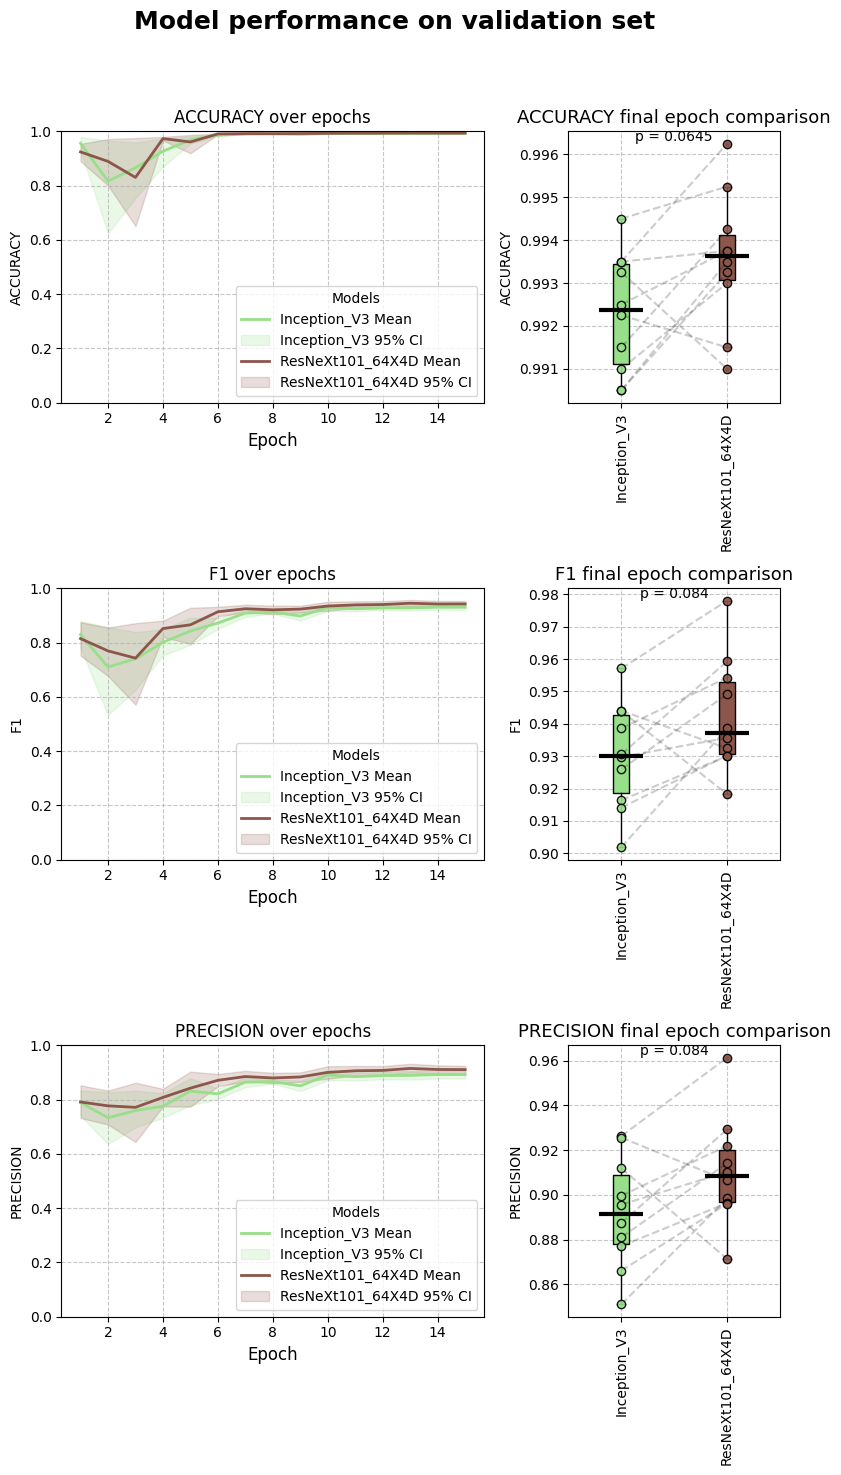

In [ ]:
metrics = ['accuracy', 'f1', 'precision']

num_metrics = len(metrics)

fig = plt.figure(figsize=(8, 5 * num_metrics))
gs = GridSpec(num_metrics, 2, width_ratios=[2, 1], figure=fig)

for i, metric in enumerate(metrics):
    fig.suptitle("Model performance on validation set", fontsize=18, fontweight='bold')#, y=0.92)

    # Epoch progression plot
    ax1 = fig.add_subplot(gs[i, 0])
    plot_epoch_progression(
        datasets=results,
        model_names=model_names,
        colors=colors,
        metric_key=metric,
        ax=ax1
    )
    ax1.set_title(f'{metric.upper()} over epochs')

    # Final epoch boxplot with stats
    ax2 = fig.add_subplot(gs[i, 1])
    plot_final_epoch(
        datasets=results,
        model_names=model_names,
        colors=colors,
        blank_space=0.0000001,
        metric_key=metric,
        ax=ax2
    )

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# 10-fold CV, specifications 
df = kfold_CV_table(results, model_names, list_metrics=['inference_time', 'accuracy','f1', 'precision','recall'])
# specifications
params = {col: model_params.get(col, None) for col in df.columns}
df.loc[len(df)] = params
df.to_csv(f'../experiments/2025-W18-04-29/tables/{model_names[1]}.csv')

In [178]:
pd.read_csv(f'../experiments/2025-W18-04-29/tables/{model_names[1]}__10fold_CV_results.csv')

,Metric,Inception V3,ResNeXt101 64X4D,p-value
0,Accuracy,0.9923 ± 0.0013,0.9935 ± 0.0015 ↑,0.0645†
1,F1,0.9302 ± 0.0156,0.9426 ± 0.0167 ↑,0.0840†
2,Precision,0.8922 ± 0.0234,0.9105 ± 0.0228 ↑,0.0840†
3,Recall,0.9873 ± 0.0107 ↑,0.9862 ± 0.0128,0.6250


## EfficientNet

In [271]:
metric = 'f1'
results = [results_inception, results_efficientnet]
model_names = ['Inception_V3', 'EfficientNet_b7']
colors = [family_colors['Inception'], family_colors['EfficientNet']]

Inception_V3 vs EfficientNet_b7: p-value = 0.00391


/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/3457609974.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(positions, means, color='black', marker='_', s=1000, zorder=10, edgecolor='black', linewidth=3, alpha=1)


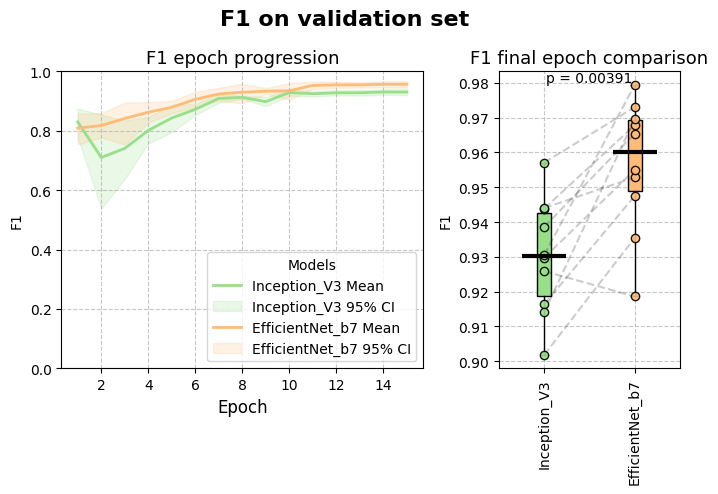

In [272]:
fig = plt.figure(figsize=(7, 5))
gs = GridSpec(1, 2, width_ratios=[2, 1], figure=fig)
fig.suptitle(f"{metric.upper()} on validation set", fontsize=16, fontweight='bold')

# epoch progression
ax1 = fig.add_subplot(gs[0])
plot_epoch_progression(
    datasets=results,
    model_names=model_names,
    colors=colors,
    metric_key=metric,
    ax=ax1
)

# final epoch comparison
ax2 = fig.add_subplot(gs[1])
plot_final_epoch(
    datasets=results,
    model_names=model_names,
    colors=colors,
    blank_space=0.00,
    metric_key=metric,
    ax=ax2 
)

plt.tight_layout()
plt.show()

Inception_V3 vs EfficientNet_b7: p-value = 0.01367
Inception_V3 vs EfficientNet_b7: p-value = 0.00391
Inception_V3 vs EfficientNet_b7: p-value = 0.00391


/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/3457609974.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(positions, means, color='black', marker='_', s=1000, zorder=10, edgecolor='black', linewidth=3, alpha=1)
/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/3457609974.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(positions, means, color='black', marker='_', s=1000, zorder=10, edgecolor='black', linewidth=3, alpha=1)
/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_72110/3457609974.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in f

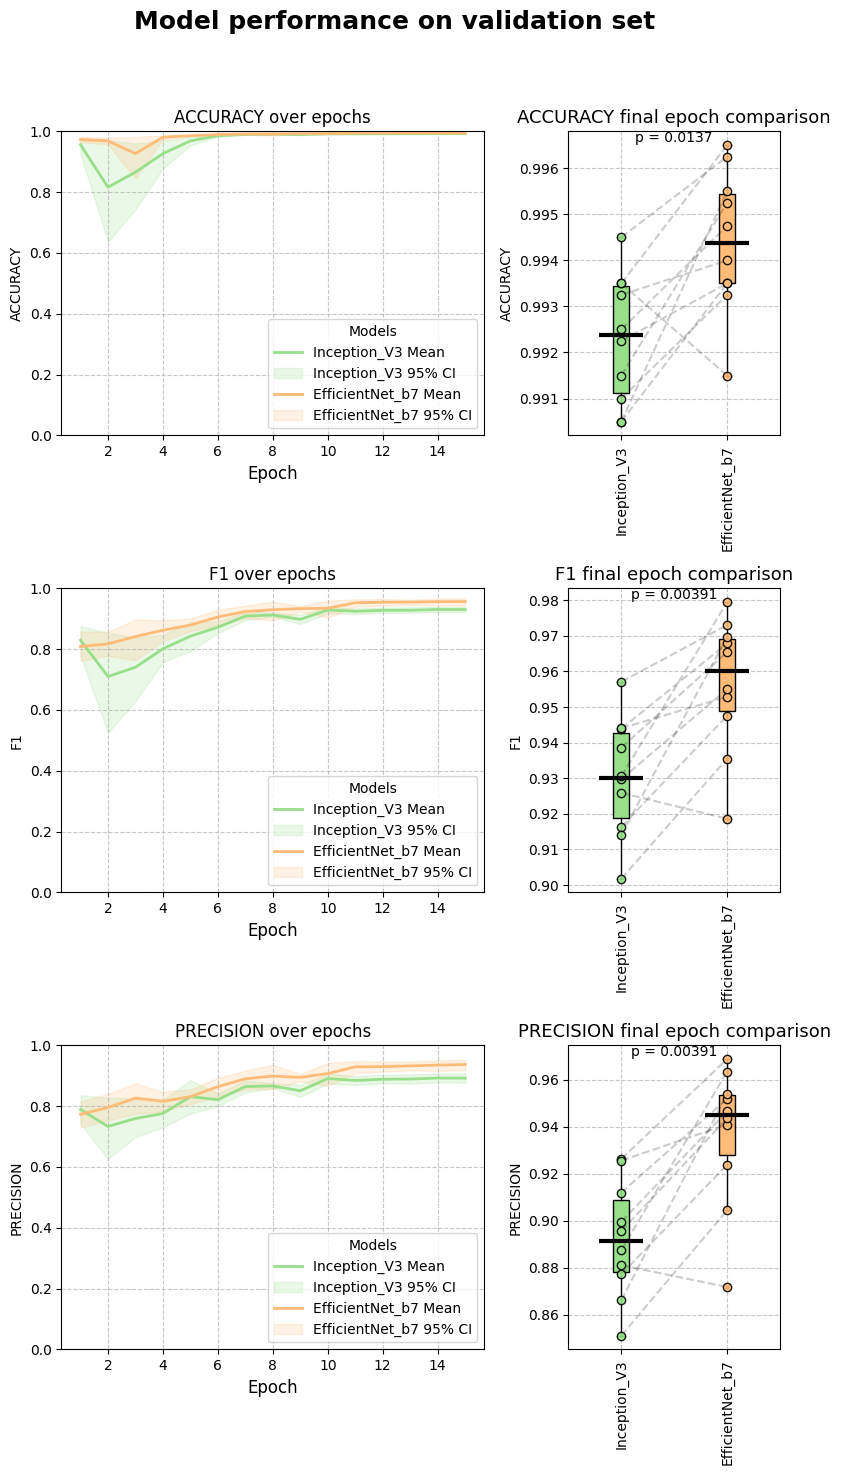

In [273]:
metrics = ['accuracy', 'f1', 'precision']

num_metrics = len(metrics)

fig = plt.figure(figsize=(8, 5 * num_metrics))
gs = GridSpec(num_metrics, 2, width_ratios=[2, 1], figure=fig)

for i, metric in enumerate(metrics):
    fig.suptitle("Model performance on validation set", fontsize=18, fontweight='bold')#, y=0.92)

    # Epoch progression plot
    ax1 = fig.add_subplot(gs[i, 0])
    plot_epoch_progression(
        datasets=results,
        model_names=model_names,
        colors=colors,
        metric_key=metric,
        ax=ax1
    )
    ax1.set_title(f'{metric.upper()} over epochs')

    # Final epoch boxplot with stats
    ax2 = fig.add_subplot(gs[i, 1])
    plot_final_epoch(
        datasets=results,
        model_names=model_names,
        colors=colors,
        blank_space=0.0000001,
        metric_key=metric,
        ax=ax2
    )

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# 10-fold CV, specifications 
df = kfold_CV_table(results, model_names, list_metrics=['inference_time', 'accuracy','f1', 'precision','recall'])
# specifications
params = {col: model_params.get(col, None) for col in df.columns}
df.loc[len(df)] = params
df.to_csv(f'../experiments/2025-W18-04-29/tables/{model_names[1]}.csv')

In [188]:
pd.read_csv(f'../experiments/2025-W18-04-29/tables/{model_names[1]}__10fold_CV_results.csv')

,Metric,Inception V3,EfficientNet b7,p-value
0,Accuracy,0.9923 ± 0.0013,0.9944 ± 0.0015 ↑,0.0137*
1,F1,0.9302 ± 0.0156,0.9565 ± 0.0178 ↑,0.0039**
2,Precision,0.8922 ± 0.0234,0.9369 ± 0.0280 ↑,0.0039**
3,Recall,0.9873 ± 0.0107 ↑,0.9816 ± 0.0101,0.1309


## Overall comparison

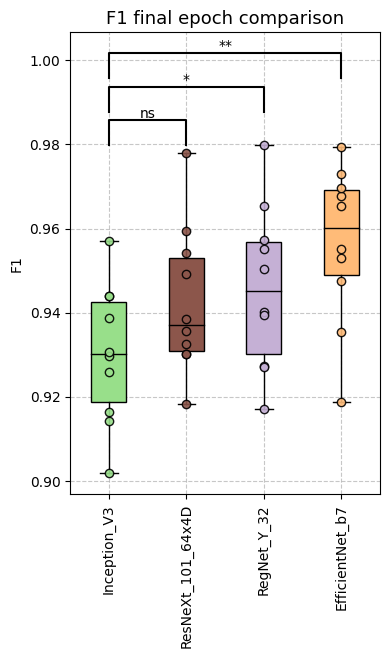

In [ ]:
def add_stat_annotation(ax, x1, x2, y, h, text):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x1 + x2) * 0.5, y + h, text, ha='center', va='bottom', fontsize=10)


def plot_final_epoch_4nn_with_stats(datasets, model_names, colors, blank_space, metric_key='f1', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    final_metrics = [
        [fold['epochs'][-1]['validation'][metric_key] for fold in data['folds']]
        for data in datasets
    ]

    box = ax.boxplot(final_metrics, labels=model_names, patch_artist=True,
                     medianprops=dict(color='black'),
                     flierprops=dict(marker='o', markerfacecolor='black', markersize=3, linestyle='none', markeredgecolor='gray'))

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    positions = list(range(1, len(final_metrics) + 1))
    for pos, group, color in zip(positions, final_metrics, colors):
        jitter = np.random.normal(0, 0.00, size=len(group))
        ax.scatter([pos + j for j in jitter], group, alpha=0.9, color=color,
                   edgecolor='black', linewidth=1, zorder=3)

    for i in range(len(final_metrics[0])):
        x_vals = [pos + np.random.normal(0, 0.00) for pos in positions]
        y_vals = [final_metrics[nn][i] for nn in range(len(final_metrics))]
        ax.plot(x_vals, y_vals, color='black', alpha=0.0, zorder=1, linestyle='--')

    # stat annotation
    y_base = max([max(m) for m in final_metrics])
    h = blank_space * 0.3

    for i in range(1, len(final_metrics)):
        stat, p = wilcoxon(final_metrics[0], final_metrics[i])
        if p < 0.001:
            text = '***'
        elif p < 0.01:
            text = '**'
        elif p < 0.05:
            text = '*'
        else:
            text = 'ns'
        add_stat_annotation(ax, positions[0], positions[i], y_base, h, text)
        y_base += blank_space * 0.4  

    ax.set_xticklabels(model_names, rotation=90)
    ax.set_ylabel(metric_key.upper())
    ax.set_title(f"{metric_key.upper()} final epoch comparison", fontsize=13)
    ax.grid(True, linestyle='--', alpha=0.7)

    if ax.get_legend():
        ax.legend_.remove()

    return ax

fig, ax = plt.subplots(figsize=(4, 6))
metric = 'f1'
results = [results_inception, results_resnext, results_regnet, results_efficientnet]
model_names = ['Inception_V3', 'ResNeXt_101_64x4D','RegNet_Y_32','EfficientNet_b7']
colors = [family_colors['Inception'], family_colors['ResNeXt'], family_colors['RegNet'], family_colors['EfficientNet']]
plot_final_epoch_4nn_with_stats(datasets, model_names, colors, blank_space=0.02, metric_key='f1', ax=ax)
plt.show()

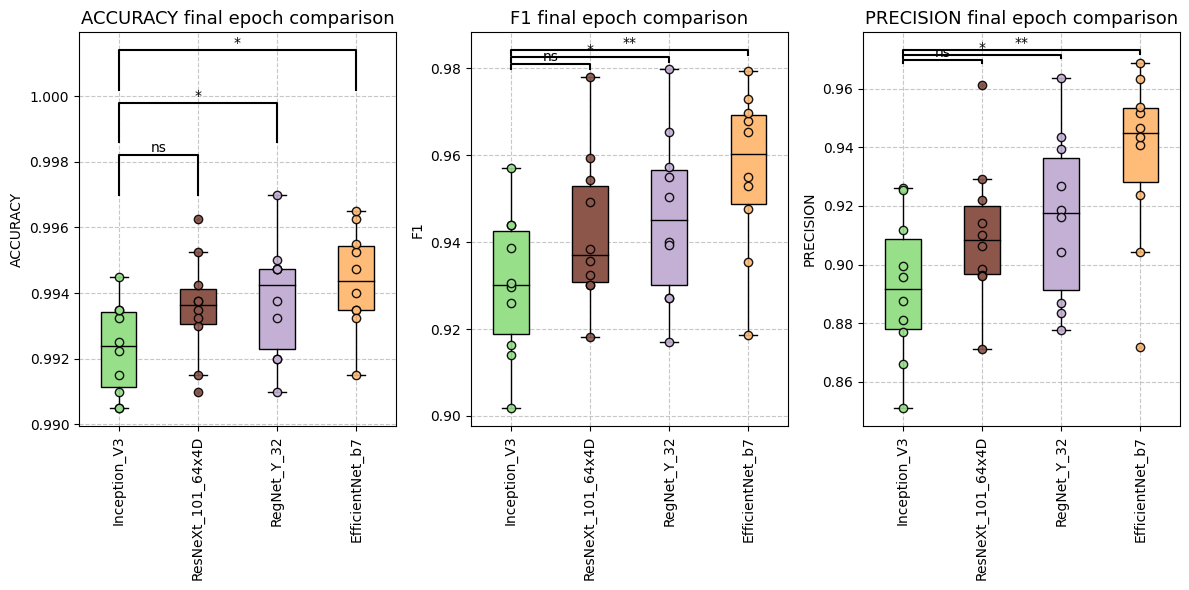

In [ ]:
metrics = ['accuracy', 'f1','precision']
model_names = ['Inception_V3', 'ResNeXt_101_64x4D', 'RegNet_Y_32', 'EfficientNet_b7']

fig, axes = plt.subplots(1, len(metrics), figsize=(4 * len(metrics), 6), sharey=False)

for ax, metric in zip(axes, metrics):
    plot_final_epoch_4nn_with_stats(datasets, model_names, colors, blank_space=0.004, metric_key=metric, ax=ax)

plt.tight_layout()
plt.show()